In [1]:
from models.resnet_model import get_resnet_model
import wandb
wandb.init() 
wandb.config.NUM_CLASSES = 2
from torchvision import transforms
from preprocessing.clahe import CLAHETransform
from dataset_handler.dataset import ImageDataset
import torch
wandb.config.USE_TRANSFORM_AUGMENTATION_IN_TRAINING = True
wandb.config.USE_CLAHE = False
wandb.config.TEST_DATA_DIR="data//test_cropped_data"
from torch.utils.data import DataLoader, WeightedRandomSampler
wandb.config.BATCH_SIZE = 32
wandb.config.NUM_WORKERS=1
import torch.nn as nn
wandb.config.DEVICE="cuda"
wandb.config.USE_OSTEOPENIA = True



wandb: Currently logged in as: eladlaks (eladlaks-herzlia-reichman-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
size = (512, 512)
prepare_to_network_transforms = [
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
augmentation_transform = [
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Small shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust contrast
]

all_transformation = []
train_transformations = []
if wandb.config.USE_TRANSFORM_AUGMENTATION_IN_TRAINING:
    train_transformations += augmentation_transform
if wandb.config.USE_CLAHE:
    all_transformation += (
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    )  # Apply CLAHE with custom parameters

all_transformation += prepare_to_network_transforms
eval_transform = transforms.Compose(all_transformation)



test_dataset = ImageDataset(wandb.config.TEST_DATA_DIR)
test_dataset.transform = eval_transform



test_loader = DataLoader(
    test_dataset,
    batch_size=wandb.config.BATCH_SIZE,
    shuffle=False,
    num_workers=wandb.config.NUM_WORKERS,
)
# Define loss criterion
criterion = nn.CrossEntropyLoss()


In [3]:
from models.resnet_model import get_resnet_model

model = get_resnet_model(weights_path="/workspace/osteoporosis_project/saved_models/ResNet50_best.pth")
# model = get_resnet_model()


/workspace/osteoporosis_project/models/resnet_model.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=wandb.config.DEVI

In [32]:
model.to(wandb.config.DEVICE)

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(wandb.config.DEVICE)
        labels = labels.to(wandb.config.DEVICE)
        outputs = model(images)
        # loss = criterion(outputs, labels)
        # test_loss += loss.item() * images.size(0)

        # if wandb.config.USE_OSTEOPENIA:
        #     _, predicted = torch.max(outputs.data, 1)
        #     probs = torch.softmax(outputs, dim=1) 
        #     print("hi")
        # else:
        probs = torch.softmax(outputs, dim=1)
        predicted = torch.tensor(
            [0 if p[0] >0.51 else 2 if p[1] > 0.51 else 1 for p in probs]
        ).to(wandb.config.DEVICE)
        print(probs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / total



tensor([[0.4015, 0.5985],
        [0.3517, 0.6483],
        [0.7273, 0.2727],
        [0.9676, 0.0324],
        [0.1336, 0.8664],
        [0.5567, 0.4433],
        [0.0708, 0.9292],
        [0.2214, 0.7786],
        [0.0807, 0.9193],
        [0.2198, 0.7802],
        [0.9788, 0.0212],
        [0.6305, 0.3695],
        [0.9367, 0.0633],
        [0.4140, 0.5860],
        [0.4692, 0.5308],
        [0.9882, 0.0118],
        [0.7287, 0.2713],
        [0.5486, 0.4514],
        [0.2296, 0.7704],
        [0.2594, 0.7406],
        [0.9622, 0.0378],
        [0.9103, 0.0897],
        [0.9731, 0.0269],
        [0.8755, 0.1245],
        [0.9930, 0.0070],
        [0.9907, 0.0093],
        [0.9850, 0.0150],
        [0.6252, 0.3748],
        [0.4556, 0.5444],
        [0.4189, 0.5811],
        [0.9784, 0.0216],
        [0.9642, 0.0358]], device='cuda:0')
tensor([[0.0283, 0.9717],
        [0.2618, 0.7382],
        [0.1004, 0.8996],
        [0.8926, 0.1074],
        [0.8854, 0.1146],
        [0.6674, 0.3

In [33]:
test_accuracy

0.25722543352601157

In [34]:
print(all_labels,
all_preds,
all_probs)

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)

In [35]:
import pandas as pd
df = pd.DataFrame({
    'labels': all_labels,
    'preds': all_preds,
    'probs': all_probs
})

print(df)

     labels  preds                      probs
0         0      2    [0.40146235, 0.5985376]
1         0      2    [0.3517363, 0.64826375]
2         0      0     [0.7272771, 0.2727229]
3         0      0  [0.96762455, 0.032375485]
4         0      2    [0.13358401, 0.8664159]
..      ...    ...                        ...
341       2      2   [0.0069089793, 0.993091]
342       2      2   [0.020905133, 0.9790949]
343       2      2     [0.20399703, 0.796003]
344       2      2   [0.32908252, 0.67091745]
345       2      2  [0.018601805, 0.98139817]

[346 rows x 3 columns]


In [36]:
df

,labels,preds,probs
0,0,2,"[0.40146235, 0.5985376]"
1,0,2,"[0.3517363, 0.64826375]"
2,0,0,"[0.7272771, 0.2727229]"
3,0,0,"[0.96762455, 0.032375485]"
4,0,2,"[0.13358401, 0.8664159]"
...,...,...,...
341,2,2,"[0.0069089793, 0.993091]"
342,2,2,"[0.020905133, 0.9790949]"
343,2,2,"[0.20399703, 0.796003]"
344,2,2,"[0.32908252, 0.67091745]"


Text(0.5, 1.0, 'Confusion Matrix - ')

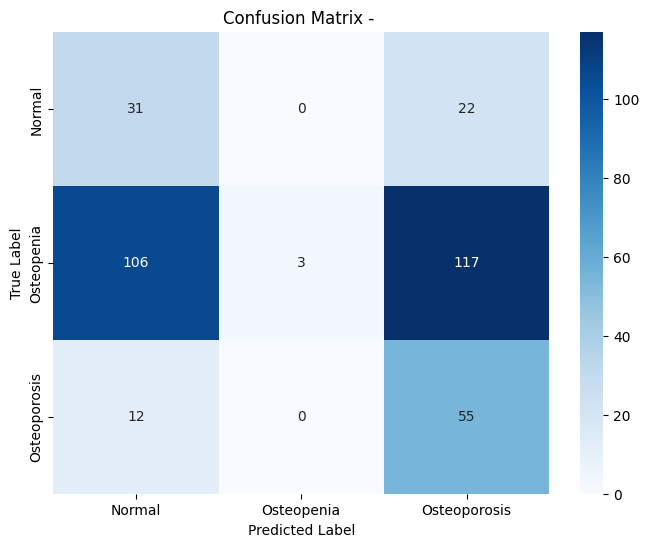

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
# Convert to numpy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)
all_probs_np = np.array(all_probs)

cm = confusion_matrix(all_labels_np, all_preds_np)
class_names = ["Normal", "Osteopenia", "Osteoporosis"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - ")
